# Working with Text Data

Text data is usually represented as strings, made up of characters. We need a way to process this data before using it in a machine learning algorithm.

## Types of Data Represented as Strings

Text is typically represented as strings, but strings are not necessarily just text. The only way to know how to treat a string feature is to look at the data. The four kinds of string data you could see are:

- Categorical data
    - Comes from a fixed list.
- Free strings that can be semantically mapped to categories
    - Data likely taken from a text field that can be mapped to categories.
- Structured string data
    - This type of data does not correspond to fixed categories but may still have some underlying structure. It's often very difficult to parse.
- Text data
    - This is freeform text data.

## Example Application: Sentiment Analysis of Movie Reviews

We will use a dataset of movie reviews from IMDB. This dataset contains the text of the reviews, together with a label that indicates whether a review is “positive” or “negative.” The IMDb website itself contains ratings from 1 to 10. To simplify the modeling, this annotation is summarized as a two-class classification dataset where reviews with a score of 6 or higher are labeled as positive, and the rest as negative.

In [2]:
import numpy as np

# (Stop convergence warning messages):
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
# Look at the data
!tree -L 2 ../aclimdb

../aclimdb
├── imdbEr.txt
├── imdb.vocab
├── README
├── test
│   ├── labeledBow.feat
│   ├── neg
│   ├── pos
│   ├── urls_neg.txt
│   └── urls_pos.txt
└── train
    ├── labeledBow.feat
    ├── neg
    ├── pos
    ├── unsup
    ├── unsupBow.feat
    ├── urls_neg.txt
    ├── urls_pos.txt
    └── urls_unsup.txt

7 directories, 11 files


In [4]:
# The load_files helper function in scikit-learn loads files stored in the folder structure seen above.
# Load the training data

from sklearn.datasets import load_files

reviews_train = load_files("../aclimdb/train/")

# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target

# Print info
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[1]:\n{}".format(text_train[1]))

type of text_train: <class 'list'>
length of text_train: 75000
text_train[1]:
b"Amount of disappointment I am getting these days seeing movies like Partner, Jhoom Barabar and now, Heyy Babyy is gonna end my habit of seeing first day shows.<br /><br />The movie is an utter disappointment because it had the potential to become a laugh riot only if the d\xc3\xa9butant director, Sajid Khan hadn't tried too many things. Only saving grace in the movie were the last thirty minutes, which were seriously funny elsewhere the movie fails miserably. First half was desperately been tried to look funny but wasn't. Next 45 minutes were emotional and looked totally artificial and illogical.<br /><br />OK, when you are out for a movie like this you don't expect much logic but all the flaws tend to appear when you don't enjoy the movie and thats the case with Heyy Babyy. Acting is good but thats not enough to keep one interested.<br /><br />For the positives, you can take hot actresses, last 30 minutes,

In [5]:
# This data is newer than the book data, so we'll remove all elements of text_train and y_train which have a label of '2'.
index_throw = np.where(y_train == 2)
index_throw = index_throw[0]
y_train = np.delete(y_train, index_throw)
text_train = np.delete(text_train, index_throw)

In [6]:
# Reprint info
# Print info
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[1]:\n{}".format(text_train[1]))

type of text_train: <class 'numpy.ndarray'>
length of text_train: 25000
text_train[1]:
b'If you want Scream or anything like the big-studio horror product that we get forced on us these days don\'t bother. This well-written film kept me up thinking about all it had to say. Importance of myth in our lives to make it make sense, how children interpret the world (and the violence in it), our ransacking of the environment and ignorance of its history and legends.. all here, but not flatly on the surface. You could technically call it a "monster movie" even though the Wendigo does not take physical form until the end, and then it\'s even up to you and your beliefs as to what\'s happening with the legendary spirit/beast. Some standard thriller elements for those looking just for the basics and the film never bores, though in fact the less you see of the creature, the better. Fessenden successfully continues George Romero\'s tradition of using the genre as parable and as a discussion forum wh

In [7]:
# Remove the html line breaks from the text train
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [8]:
# See balance of positive/negative review
print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [12500 12500]


In [9]:
# Load the test dataset
reviews_test = load_files("../aclimdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Number of documents in test data: 25000
Samples per class (test): [12500 12500]


Our goal now is to do stanard binary classification: assign "positive" or "negative" based on the text context of the review. We need to convert the string representation of the text into a numeric representation first.

## Representing Text Data as a Bag of Words

This approach discards most of the structure of the input text and simply counts how often each word appears in each text. We have three steps to get a bag-of-words representation:

1. Tokenization: split each document into the words that appear in it (called tokens).
2. Vocabulary building: collect a vocabulary of all words that appear in any of the documents and number them.
3. Encoding: for each document, cound how often each of the words in the vocabulary appear in this document.

### Applying Bag-of-Words to a Toy Dataset

In [10]:
# bag-of-words representation is implemented in CountVectorizer, which is a transformer. We'll first apply it to a toy dataset consisting of two samples.
bards_words =["The fool doth think he is wise,", "but the wise man knows himself to be a fool"]

In [11]:
# Import and instantiate the CountVectorizer and fit it to the toy data
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [12]:
# See the build vocabulary with the vocabulary_ attribute
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [13]:
# Now create the bag-of-words representation with the transform method
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [14]:
# We store the bag-of-words as a sparse matrix, since the number of words in any give document is far less than the whole vocabulary.
# To see the dense representation we convert to a dense NumPy array with toarray

print("Dense representation of bag_of_words:\n{}".format(bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


### Bag-of-Words for Movie Reviews

In [15]:
# Transform the movie reviews dataset

vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [16]:
# Look at the vocabulary in a bit more detail:

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))


Number of features: 74849
First 20 features:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Features 20010 to 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Every 2000th feature:
['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


In [17]:
# Check if 007 entry is related to James Bond
bond_word = b'007'
bond_check = [entry for entry in text_train if bond_word in entry]
print(bond_check)

[b"please, future writers, producers, directors - learn from this movie!  never before have i seen such a bold and original tale created for the big movie screen. bold, because the script constantly made a step so many fantasy movies safely avoided - a step to something new, creative and daring. just when you think 'oh, i've seen this before' or 'i am sure this is what will happen now' - StarDust would make an unexpected twist and involve you more and more into the story.  the actors are great - even the smallest part is performed with such talent it fills me with awe for the creators of this movie. Robert De Niro is gorgeous and performs with such energy that he simply steals the show in each scene he's in. Michelle Pfeiffer is the perfect witch, and Claire Danes a wonderful choice for the innocent and loving 'star', Yvaine. Other big names make outstanding roles. I had the filling everyone is trying to give his best for this movie. But once again, the story by Neil Gaiman, all the li

In [18]:
# We'll build a logistic regression classifier using the bag-of-words classifier.
# Evaluate LogisticRegression using CV.
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.88


In [19]:
# Tune the regularization parameter C with GridSearchCV.

from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.89
Best parameters:  {'C': 0.1}


In [20]:
# Test on the test set
X_test = vect.transform(text_test)
print("{:.2f}".format(grid.score(X_test, y_test)))

0.88


In [21]:
# The default extraction mechanism for CountVectorizer is to split as "\b\w\w+\b". This doesn't handle numbers like we saw earlier.
# We'll use tokens that appear in a least five documents, since a token that appears in only a single document is unlikely to appear
# in the test set.

vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [22]:
# Look at the reduced tokens:

feature_names = vect.get_feature_names()

print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Features 20010 to 20030:
['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
Every 700th feature:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciati

In [23]:
# Re-do the grid search on this

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


## Stopwords

We can help get rid of uninformative words by discarding words that are too frequent to be informative. The two ways to accomplish this are by using a language-specific list of stopwords or discarding words that appear too frequently. 

In [24]:
# scikit-learn has a built-in list of English stopwords in the feature_extraction.text module.

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['other', 'otherwise', 'are', 'the', 'hence', 'been', 'system', 'find', 'each', 'fifty', 'ten', 'had', 'mine', 'he', 'will', 'within', 'perhaps', 'thick', 'all', 'be', 'below', 'beside', 'while', 'into', 'eleven', 'onto', 'next', 'hundred', 'therefore', 'upon', 'under', 'enough']


In [25]:
# Try this on the movie reviews:
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [26]:
# Run the grid search again:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.88


## Rescaling the Data with tf-idf

Instead of dropping features, another approach is to resacle features by how informative we expect them to be. A common way to do this is with the term frequency-inverse document frequency (tf-idf) method. It gives high weight to any term that appears often in a particular document but not in many documents. Intuition: if a word appears often in a particular document, but not in very many documents, it is likely to be very descriptive of the content of that document.

In [28]:
# tf-idf makes use of the statistical properties of the training data, so we'll use a pipeline to ensure the results of the grid search are valid.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


In [29]:
# Extract TfidfVEctorizer from the pipeline in order to find the words that tf-idf found most/least important.

# Most important:

vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:20]]))
print("Features with highest tfidf: \n{}".format(feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest tfidf: 
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


In [30]:
# Least important

sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


## Investigating Model Coefficients

There are a lot of features in this dataset, so we'll look at the largets coefficients to try to get a sense of the most important features.

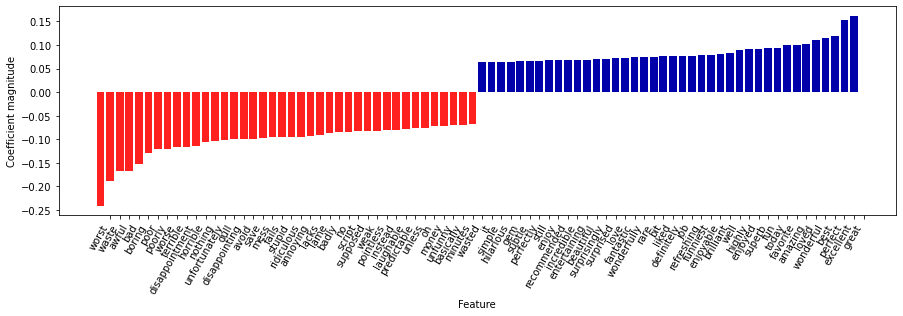

In [32]:
# Show the 25 largest and smallest coefficients in the logistic regression model
import mglearn

mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps["logisticregression"].coef_, feature_names, n_top_features=40)

## Bag-of-Words with More Than One Word (n-Grams)

The bag-of-words method is effective, but limited by the fact that word order is ignored. For instance, the strings “it’s bad, not good at all” and “it’s good, not bad at all” have exactly the same representation, even though the meanings are inverted. We can instead consider pairs or triplets or "n-lets" of tokens that appear next to each other, giving some additional context to individual words.

In [33]:
# The ngram_range parameter controls the number of words we consider as a single feature.

# Return to the toy bard dataset:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [34]:
# The default is to use unigrams
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [35]:
# Here's the vocabulary if we instead look at bigrams:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [36]:
# Here's the look of the feature set using unigrams, bigrams, and trigrams:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


Increasing the feature set with n-grams often helps, but increasing n too much gives diminishing returns.

In [37]:
# Try TfidfVectorizer on the IMDb dataset and find the best n-gram combination using a grid search:

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())

# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100], "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.91
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


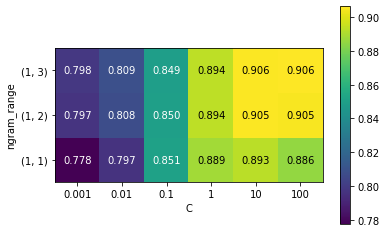

In [40]:
# We can investigate the results using a heat map as we did previously:
import matplotlib.pyplot as plt

scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = mglearn.tools.heatmap(scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f", xticklabels=param_grid['logisticregression__C'], yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap);

The heat map shows that using bigrams improves performance quite a bit, but trigrams don't do much to improve performance.

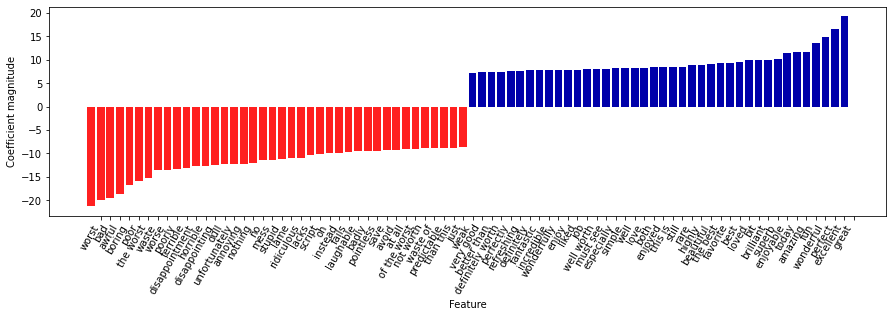

In [41]:
# Take a look at the important feature coefficients for this model:

vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

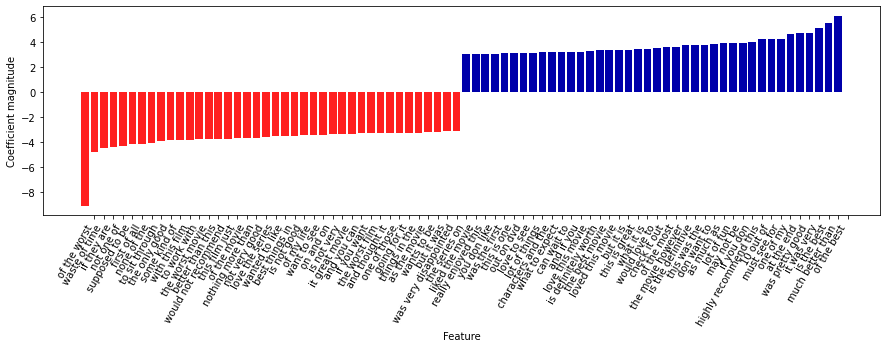

In [43]:
# The trigram features are not particularly important compared to the unigram features, as this plot shows (note the scaling of the y-axis):

# find 3-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# visualize only 3-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask], feature_names[mask], n_top_features=40)

## Advanced Tokenization, Stemming, and Lemmatization

Normalization techniques involve extracting some normal form of a word. Stemming is done by using a rule-based heuristic, like dropping common suffixes. Lemmatization finds the standardized form of a word. These can all help correct having words like "replace" , "replaced" , "replacement" , "replaces" , and "replacing" in the same vocabulary.

In [47]:
# Look at examples of stemming and lemmatization (imported from the nltk and spacy packages):
import spacy
import nltk

# load spacy's English-language models
en_nlp = spacy.load('en_core_web_sm')

# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # print lemmas found by spacy
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # print tokens found by Porter stemmer
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [49]:
# Compare the normalization using a designed example:
compare_normalization(u"Our meeting today was worse than yesterday, " "I'm scared of meeting the clients tomorrow.")

Lemmatization:
['our', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', 'I', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


In [56]:
# scikit-learn implements neither stemming nor normalization, but CountVectorizer allows specifying your own tokenizer.

# Use the lemmatization from spacy to create a callable that will take a string and produce a list of lemmas:
import re
# regexp used in CountVectorizer
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model and save old tokenizer
en_nlp = spacy.load('en_core_web_sm')
old_tokenizer = en_nlp.tokenizer
# replace the tokenizer with the preceding regexp
# en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# create a custom tokenizer using the spacy document processing pipeline
# (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [57]:
# Transform the data and inspect the vocabulary size
# transform text_train using CountVectorizer with lemmatization

X_train_lemma = lemma_vect.fit_transform(text_train)
print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

# standard CountVectorizer for reference
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train.shape: {}".format(X_train.shape))

KeyboardInterrupt: 

## Topic Modeling and Document Clustering

Topic modeling describes the task of assigning a document to one or multiple topic. If each document is assigned a single topic, this is called clustering. If each document can have multiple topics, this task is related to decomposition. An often used topic modeling method is called Latent Dirichlet Allocation.

### Latent Dirichlet Allocation

This approach seeks to find groups of words that appear together frequently. It also requires that each document can be understood as a mixture of a subset of topics. These topics might not be traditional "topics" used in everyday speech, but might resemble more components extracted by PCA or NMF.

In [58]:
# Apply LDA to our movie review dataset. First remove common words (that appear in at least 20% of the documents) and then
# limit the bag-of-words model to the 10,000 words that are most common after removing the top 20%.

vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

In [60]:
# Learn a topic model with 10 topics.

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0)

# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

In [61]:
# Look at the most important words for each of the topics

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
real          world         comedy        series        saw           
young         us            guy           episode       thought       
family        our           re            tv            am            
performance   american      laugh         episodes      got           
both          documentary   stupid        shows         10            
beautiful     history       thing         new           thing         
work          years         fun           season        want          
each          new           worst         years         watched       
director      own           actually      musical       going         


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
acti

This chapter ends with an example of learning 100 topics using LDA, but that would likely take a long time to compute on this machine.